Saving MRI.jpeg to MRI (1).jpeg


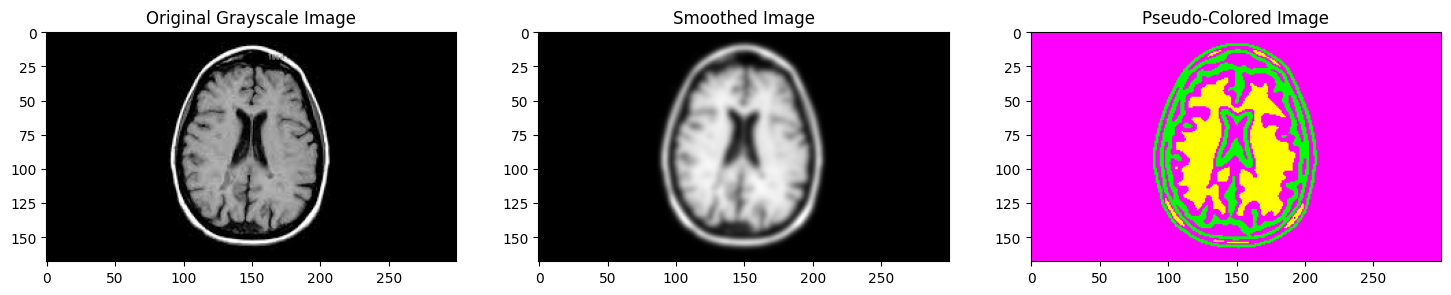

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import gaussian
from google.colab import files
from io import BytesIO
from PIL import Image

def upload_image():
    uploaded = files.upload()
    image_path = next(iter(uploaded))
    return image_path, uploaded

def fitness_function(pseudo_colors, smoothed_image, n_components):
    # Calculate differences along axis 2 (color channels)
    diff_x = np.abs(np.diff(pseudo_colors, axis=0))
    diff_y = np.abs(np.diff(pseudo_colors, axis=1))
    total_contrast = np.sum(diff_x) + np.sum(diff_y)
    return -total_contrast

def apply_pseudo_color(smoothed_image, pseudo_colors):
    # Apply the pseudo-coloring to the smoothed image
    pseudo_colored_image = np.zeros((smoothed_image.shape[0], smoothed_image.shape[1], 3))
    for i in range(pseudo_colors.shape[0]):
        mask = (smoothed_image >= i / pseudo_colors.shape[0]) & (smoothed_image < (i + 1) / pseudo_colors.shape[0])
        pseudo_colored_image[mask] = pseudo_colors[i] / 255.0  # Normalize to [0, 1]
    return pseudo_colored_image

def pseudo_color_image(image_path, uploaded, n_components):
    image_data = uploaded[image_path]
    image = Image.open(BytesIO(image_data))

    grayscale_image = image.convert('L')
    grayscale_array = np.array(grayscale_image)

    # Perform spatial smoothing using Gaussian filter
    smoothed_image = gaussian(grayscale_array, sigma=2)

    # Normalize the smoothed image to [0, 1]
    smoothed_image = (smoothed_image - smoothed_image.min()) / (smoothed_image.max() - smoothed_image.min())

    # Initialize PSO parameters
    num_particles = 20
    num_dimensions = n_components * 3
    max_iterations = 100
    inertia_weight = 0.7298
    cognitive_coefficient = 1.49618
    social_coefficient = 1.49618

    # Initialize particle positions and velocities
    particles_position = np.random.rand(num_particles, num_dimensions) * 255
    particles_velocity = np.random.randn(num_particles, num_dimensions) * 0.1

    # Initialize best positions found by each particle
    particles_best_position = particles_position.copy()
    particles_best_fitness = np.full(num_particles, np.inf)

    # Initialize global best position found by the swarm
    global_best_position = particles_position[0].copy()
    global_best_fitness = np.inf

    for iteration in range(max_iterations):
        for i in range(num_particles):
            # Reshape the particle position into pseudo-color components
            pseudo_colors = particles_position[i].reshape(-1, 3)

            # Evaluate fitness of current particle position
            fitness = fitness_function(pseudo_colors, smoothed_image, n_components)

            # Update personal best position
            if fitness < particles_best_fitness[i]:
                particles_best_fitness[i] = fitness
                particles_best_position[i] = particles_position[i]

                # Update global best position
                if fitness < global_best_fitness:
                    global_best_fitness = fitness
                    global_best_position = particles_position[i]

            # Update velocity
            r1, r2 = np.random.rand(2)
            cognitive_velocity = cognitive_coefficient * r1 * (particles_best_position[i] - particles_position[i])
            social_velocity = social_coefficient * r2 * (global_best_position - particles_position[i])
            particles_velocity[i] = inertia_weight * particles_velocity[i] + cognitive_velocity + social_velocity

            # Update position
            particles_position[i] = np.clip(particles_position[i] + particles_velocity[i], 0, 255)

    # Convert the best global position into pseudo-color components
    pseudo_colors = global_best_position.reshape(-1, 3)

    # Apply the pseudo-coloring to the smoothed image
    pseudo_colored_image = apply_pseudo_color(smoothed_image, pseudo_colors)

    plt.figure(figsize=(18, 6))

    plt.subplot(131)
    plt.imshow(grayscale_image, cmap='gray')
    plt.title('Original Grayscale Image')

    plt.subplot(132)
    plt.imshow(smoothed_image, cmap='gray')
    plt.title('Smoothed Image')

    plt.subplot(133)
    plt.imshow(pseudo_colored_image)
    plt.title('Pseudo-Colored Image')

    plt.show()

image_path, uploaded = upload_image()
n_components = 5
pseudo_color_image(image_path, uploaded, n_components)